In [1]:
#get 10 files, each is the same timestep for a member of a
#10 member ensemble
data_download=False
if data_download:
    root='http://clouds.eos.ubc.ca/~phil/docs/atsc500/dryles'
    for i in np.arange(1,11,dtype=np.int):
        the_name='mar12014_{:d}_15600.nc'.format(i)
        print(the_name)
        url='{}/{}'.format(root,the_name)
        urllib.request.urlretrieve(url,the_name)
           

Useful links:

We need:

* [namedtuples](https://docs.python.org/3/library/collections.html#collections.namedtuple)

* [numpy.savez](http://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html)

* [vapor](https://www.vapor.ucar.edu/)

* [vapor videos](https://www.youtube.com/channel/UCVSuoneyeZFn4Znxl_jJ70A)

* [xray and dask](https://www.continuum.io/content/xray-dask-out-core-labeled-arrays-python)

## First load a couple of utility functions

In [2]:
import glob
import xray
from matplotlib import pyplot as plt
import numpy as np
from collections import namedtuple
import textwrap

def sort_name(name):
    """
      sort the filenames so '10' sorts
      last by converting to integers
    """
    front, number, back = name.split('_')
    return int(number)


def dict_to_nt(the_dict, tupname):
    """
      convert a dictionary into a namedtuple
    """
    # first define the keys as attributes
    In_tup = namedtuple(tupname, the_dict.keys())
    # then read the key,value pairs in and assign to
    # attributes
    out_tuple = In_tup(**the_dict)
    return out_tuple


Now use xray to stitch together the 10 ensemble members along a new "virtual dimenstion".
The variable "ds"  is an xray dataset, which controls the reads/writes from the
10 netcdf files


In [3]:
the_files = glob.glob('mar*nc')
the_files.sort(key=sort_name)

#
#  put the 10 ensembles together along a new "ens" dimension
#  using an xray multi-file dataset
#
#  Checkpointing
#
#  This is slow, so only do it once, and store the variables
#  using np.savez.   Then set firstrun=False and read the 
#  variables out of the npz file instead of recalculating
#
#  Store the variables in a namedtuple so we don't have to continually
#  be typing in dictionary indices  (too many keystrokes)
#
#
firstrun = False
if firstrun:
    ds = xray.open_mfdataset(the_files, engine='netcdf4', concat_dim='ens')
    # dump the structure
    print(ds)
    #
    #  3-d ensemble average for temp
    #
    x = ds['x']
    y = ds['y']
    z = ds['z']
    temp = ds['TABS']
    mean_temp = temp[:, 0, :, :, :].mean(dim='ens')
    #
    # same for velocity
    #
    vvel = ds['V']
    mean_v = vvel[:, 0, :, :, :].mean(dim='ens')
    #
    # now look at the perturbation fields for one ensemble
    #
    vvelprime = vvel[0, 0, :, :, :] - mean_v
    Tprime = temp[0, 0, :, :, :] - mean_temp
    flux_prime = vvelprime * Tprime
    flux_profile = flux_prime.mean(dim='x').mean(dim='y')
    keep_dict = dict(flux_prof=flux_profile, flux_prime=flux_prime.values,
                     vvelprime=vvelprime.values, Tprime=Tprime.values, x=x, y=y, z=z)
    np.savez('dump.npz', **keep_dict)
    var_tup = dict_to_nt(keep_dict, 'vars')
else:
    in_dict = np.load('dump.npz')
    var_tup = dict_to_nt(in_dict, 'vars')
    print(var_tup._fields)
    vvelprime = var_tup.vvelprime


('flux_prime', 'x', 'flux_prof', 'y', 'vvelprime', 'z', 'Tprime')


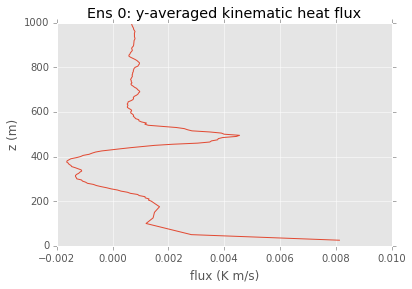

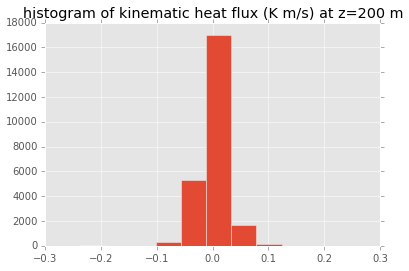

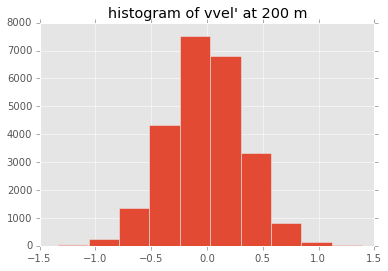

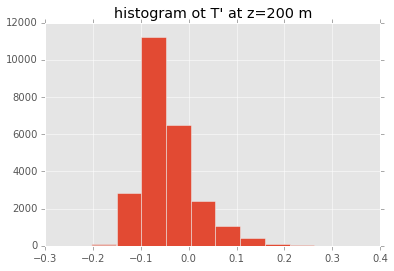

In [4]:
%matplotlib inline
plt.style.use('ggplot')
fig1, ax1 = plt.subplots(1, 1)
ax1.plot(var_tup.flux_prof, var_tup.z)
ax1.set(ylim=[0, 1000], title='Ens 0: y-averaged kinematic heat flux',
        ylabel='z (m)', xlabel='flux (K m/s)')

fig2, ax2 = plt.subplots(1, 1)
z200 = np.searchsorted(var_tup.z, 200)
ax2.hist(var_tup.flux_prime[z200, :, :].flat)
ax2.set(title='histogram of kinematic heat flux (K m/s) at z=200 m')

fig3, ax3 = plt.subplots(1, 1)
ax3.hist(var_tup.vvelprime[z200, :, :].flat)
ax3.set(title="histogram of vvel' at 200 m")

fig4, ax4 = plt.subplots(1, 1)
ax4.hist(var_tup.Tprime[z200, :, :].flat)
ax4.set(title="histogram ot T' at z=200 m")



# Conditional sampling the flux

Write 100 where there is postively buoyant ascending air and 1 everywhere else"

In [5]:
# just grab variance of vvelprime

# first convert to numpy array 
vvelprime_array = np.array(vvelprime)

# then square each element
vvelprime_var = vvelprime_array**2
    
#hit = np.logical_and(var_tup.vvelprime > 0, var_tup.Tprime > 0)
#pos_buoyant = np.ones_like(var_tup.flux_prime, dtype=np.float32)
#pos_buoyant[hit] = var_tup.flux_prime[hit]
#pos_buoyant[hit] = pos_buoyant[hit]*100.

# writing a vapor vdf file

First we need to output the x, y and z coordinates in separate files

In [6]:
if firstrun:
    filenames = ['xvals.txt', 'yvals.txt', 'zvals.txt']
    arrays = [var_tup.x, var_tup.y, var_tup.z]
    for name, vals in zip(filenames, arrays):
        with open(name, 'w') as outfile:
            #
            # write all but the last without a newline
            #
            [outfile.write('{:6.3f} '.format(item)) for item in vals.values[:-1]]
            #
            # write the last value with a newline
            #
            outfile.write('{:6.3f}\n'.format(vals.values[-1]))

Now write out the raw binary array using np.memmap

In [7]:
if firstrun:
    varname = 'vvelprime'
    out_name = '{}.bin'.format(varname)
    rev_shape = vvelprime_var.shape[::-1]
    string_shape="{}x{}x{}".format(*rev_shape)
    print('writing an array of {} of shape x,y,z= {}'.format(varname,string_shape))
    fp = np.memmap(out_name, dtype=np.float32, mode='w+', shape=vvelprime_var.shape)
    fp[...] = vvelprime_var[...]

Now write out a bash script that supply the data for vdfcreate

In [8]:
if firstrun:
    vars=dict(dim=string_shape,var='vvelprime')

    command=r"""
        vdfcreate  -xcoords xvals.txt -ycoords yvals.txt -zcoords zvals.txt \
           -gridtype stretched -dimension {dim:s} -vars3d {var:s} -numts 1 {var:s}.vdf

        raw2vdf -varname {var:s} -ts 0 {var:s}.vdf {var:s}.bin
    """
    out=textwrap.dedent(command.format_map(vars))
    with open('make_vapor.sh','w') as f:
        f.write('#!/bin/bash -v\n')
        f.write(out) 

In [9]:
!cat make_vapor.sh

#!/bin/bash -v

vdfcreate  -xcoords xvals.txt -ycoords yvals.txt -zcoords zvals.txt \
   -gridtype stretched -dimension 192x128x312 -vars3d vvelprime -numts 1 vvelprime.vdf

raw2vdf -varname vvelprime -ts 0 vvelprime.vdf vvelprime.bin


Now open a terminal (osx) or a bash-shell (windows) and setup the path for vapor
following these [osx instructions](https://www.vapor.ucar.edu/docs/vapor-installation/vapor-mac-binary-installation) or these
[windows instructions]( https://www.vapor.ucar.edu/docs/vapor-installation/vapor-windows-binary-installation)

Once you've done this, vdfcreate and raw2vdf should be in our path, and
you should  be able to do:

```bash
> bash make_vapor.sh
```

If this works, there should be a new file called

  buoyancy.vdf
  
and a new folder called

  buoyancy_data
  
Now executate

  vaporgui
  
from the same terminal

In [10]:
# make arrays of 1's (100s) and 0's
full_block = np.zeros_like(vvelprime_var)
ones_block = np.ones((200,80,110)) * 100.

z_size,y_size,x_size = ones_block.shape

# embed ones block into middle of zeros block
zeros_middle = np.array(full_block.shape)/2
z_start,y_start,x_start = zeros_middle - np.array(ones_block.shape)/2

full_block[z_start:z_start+z_size,y_start:y_start+y_size,x_start:x_start+x_size] = ones_block


In [11]:
firstrun = False

if firstrun:
    varname = 'block'
    out_name = '{}.bin'.format(varname)
    rev_shape = full_block.shape[::-1]
    string_shape="{}x{}x{}".format(*rev_shape)
    print('writing an array of {} of shape x,y,z= {}'.format(varname,string_shape))
    fp = np.memmap(out_name, dtype=np.float32, mode='w+', shape=full_block.shape)
    fp[...] = full_block[...]

In [12]:
if firstrun:
    vars=dict(dim=string_shape,var='block')

    command=r"""
        vdfcreate  -xcoords xvals.txt -ycoords yvals.txt -zcoords zvals.txt \
           -gridtype stretched -dimension {dim:s} -vars3d {var:s} -numts 1 {var:s}.vdf

        raw2vdf -varname {var:s} -ts 0 {var:s}.vdf {var:s}.bin
    """
    out=textwrap.dedent(command.format_map(vars))
    with open('make_block.sh','w') as f:
        f.write('#!/bin/bash -v\n')
        f.write(out) 